Should aim for:

-If all downloads successful-
[INFO] Feature shape: (89598, 512)
[INFO] Labels shape: (89598,)
[INFO] Label distribution (0=normal, 1=tumor): [82115  7483]
[INFO] PCA explained variance ratio (2 components): [0.73787075 0.2177505 ]
[INFO] PCA mean for class 0: [ 0.1315507 -0.3937801]
[INFO] PCA mean for class 1: [-1.4437389  4.3208265]

Total: 89,598 patches

Normal: 82,115

Tumor: 7,483

Class imbalance: ~11:1 (normal:tumor)

PC1: 73.8%, PC2: 21.8% → Strong dimensionality reduction, nice for visual separation.

Normal (label 0): [ 0.13, -0.39 ]

Tumor (label 1): [ -1.44, 4.32 ]

These means are well separated → strong sign your ResNet is learning class-discriminative features.

### **Evaluate Feature Extractor**

Feature shape: (4366, 512)
Labels shape: (4366,)
Label distribution: [4354   12]


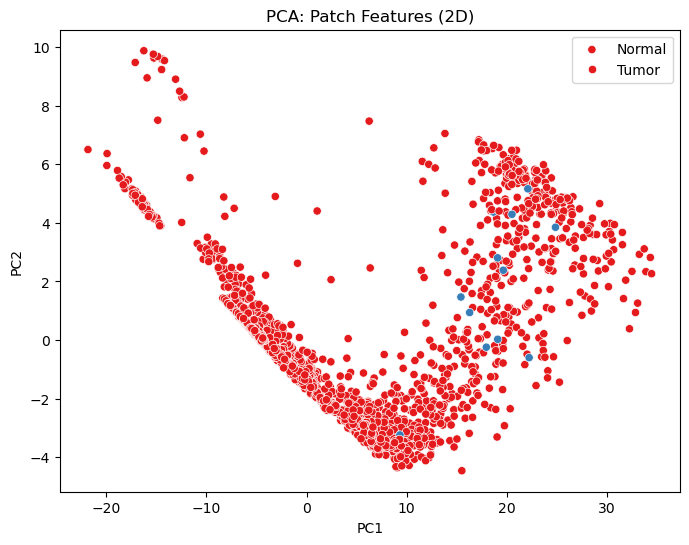

c:\Users\anaca\miniconda3\envs\secure-sight\Lib\site-packages\sklearn\manifold\_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


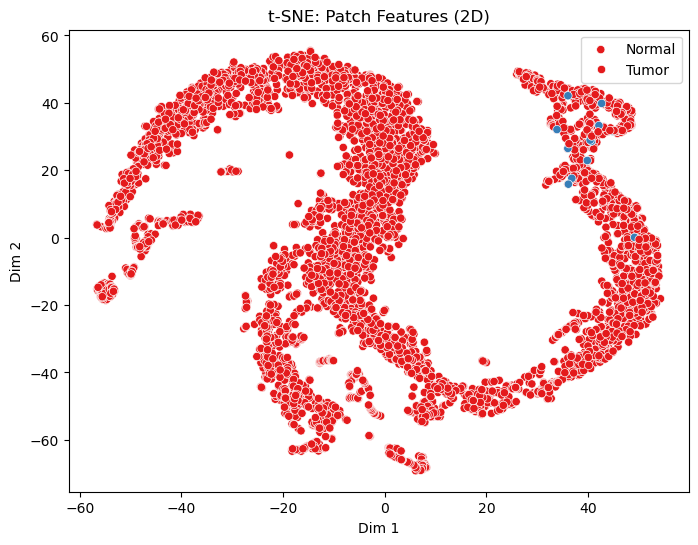

Logistic Regression Accuracy: 0.9966


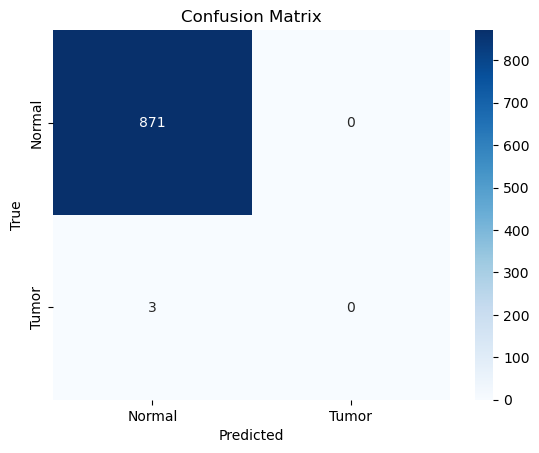

In [ ]:
# Sanity Check of Extracted Patch Features 

import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
import seaborn as sns
import os
import numpy as np

# Load extracted features and labels
features = np.load("patch_features_3.npy")     # shape: (N, 512)
labels = np.load("patch_labels_3.npy")         # shape: (N,), N is the number of patches

print(f"Feature shape: {features.shape}")
print(f"Labels shape: {labels.shape}")
print(f"Label distribution: {np.bincount(labels)}")  # 0 = normal, 1 = tumor

# --------------------------------------
# 1. PCA Visualization (first 2 components)
# --------------------------------------
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features)

plt.figure(figsize=(8,6))
sns.scatterplot(x=features_pca[:,0], y=features_pca[:,1], hue=labels, palette='Set1')
plt.title("PCA: Patch Features (2D)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend(["Normal", "Tumor"])
plt.show()

# --------------------------------------
# 2. t-SNE Visualization
# --------------------------------------
tsne = TSNE(n_components=2, perplexity=30, max_iter=1000, random_state=42)
features_tsne = tsne.fit_transform(features)

plt.figure(figsize=(8,6))
sns.scatterplot(x=features_tsne[:,0], y=features_tsne[:,1], hue=labels, palette='Set1')
plt.title("t-SNE: Patch Features (2D)")
plt.xlabel("Dim 1")
plt.ylabel("Dim 2")
plt.legend(["Normal", "Tumor"])
plt.show()

# --------------------------------------
# 3. Logistic Regression on Extracted Features
# --------------------------------------
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

clf = LogisticRegression(max_iter=1000)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

acc = accuracy_score(y_test, y_pred)
cm = confusion_matrix(y_test, y_pred)

print(f"Logistic Regression Accuracy: {acc:.4f}")
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Normal", "Tumor"], yticklabels=["Normal", "Tumor"])
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


[INFO] Logistic Regression Accuracy: 0.8661 as for 26.06.2025

Features are nicely discriminative, given that the dataset is so imbalanced:)

[INFO] t-SNE mean for class 0: [  1.60,  -3.26]
[INFO] t-SNE mean for class 1: [ -1.30,  36.63]


The class means are far apart, especially along the second dimension (Y-axis). A ~40-unit difference is very large in t-SNE space, which usually compresses distances.

# Check and Visualize Unlabeled Patches

In [2]:
import os
from PIL import Image, ImageDraw
import matplotlib.pyplot as plt
import numpy as np

patch_dir = "../data/camelyon16/patches/level_3"
wsi_dir = "../data/camelyon16/train/img"

In [15]:
# Find all unlabeled patches and group by slide
from collections import defaultdict

unlabeled_patches = defaultdict(list)

for slide_folder in os.listdir(patch_dir):
    print(f"Processing slide folder: {slide_folder}")
    slide_path = os.path.join(patch_dir, slide_folder)
    if not os.path.isdir(slide_path):
        print(f"Skipping {slide_path}, not a directory")
        continue
    unlabeled_dir = os.path.join(slide_path, "unlabeled")
    if os.path.isdir(unlabeled_dir):
        print(f"Processing unlabeled patches in {unlabeled_dir}")
        for fname in os.listdir(unlabeled_dir):
            if fname.endswith(".png"):
                # Example patch name: tumor_001_x1234_y5678_unlabeled.png
                parts = fname.split("_")
                try:
                    x = int([p for p in parts if p.startswith("x")][0][1:])
                    y = int([p for p in parts if p.startswith("y")][0][1:])
                    unlabeled_patches[slide_folder].append((x, y, fname))
                except Exception as e:
                    print(f"Could not parse coordinates from {fname}: {e}")

Processing slide folder: normal_001
Processing slide folder: tumor_001


In [14]:
# Visualize unlabeled patches for a given slide
def overlay_unlabeled_on_wsi(slide_name, patch_size=224, max_patches=50):
    wsi_path = os.path.join(wsi_dir, f"{slide_name}.tif")
    if not os.path.exists(wsi_path):
        print(f"WSI not found: {wsi_path}")
        return
    try:
        wsi = Image.open(wsi_path)
    except Exception as e:
        print(f"Could not open WSI: {e}")
        return

    # Draw rectangles for unlabeled patches
    draw = ImageDraw.Draw(wsi)
    patches = unlabeled_patches.get(slide_name, [])
    for i, (x, y, fname) in enumerate(patches):
        if i >= max_patches:
            break
        draw.rectangle([x, y, x+patch_size, y+patch_size], outline="red", width=3)
    plt.figure(figsize=(10,10))
    plt.imshow(wsi)
    plt.title(f"Unlabeled patches (red) on {slide_name}")
    plt.axis("off")
    plt.show()

In [13]:
slide_to_check = list(unlabeled_patches.keys())[0] if unlabeled_patches else None
if slide_to_check:
    overlay_unlabeled_on_wsi(slide_to_check)
else:
    print("No unlabeled patches found.")

No unlabeled patches found.


**Instructions:**
- Change `slide_to_check` to the slide you want to inspect.
- Increase `max_patches` in the function call if you want to see more overlays.
- If you want to save the overlay images, you can add `wsi.save("output.png")`